In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
from tensorflow.keras import losses
import pickle

# import own modules  
from fashion_similarities.utils import GetSimpleData
from fashion_similarities.lsh import LSH
from fashion_similarities.autoencoder import Autoencoder

In [4]:
data_loader = GetSimpleData()
x_train, y_train = data_loader.load_mnist()
x_test, y_test = data_loader.load_mnist(kind="test")
x_train = x_train.reshape(len(y_train), 28, 28)
x_test = x_test.reshape(len(y_test), 28, 28)

In [5]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

In [6]:
latent_dim = 64
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0234 - val_loss: 0.0135
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.008

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

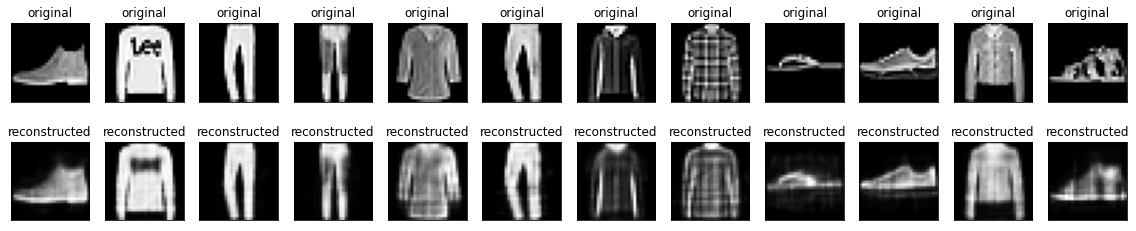

In [8]:
n = 12
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
embedding = autoencoder.encoder(x_train).numpy()

In [10]:
embedding.shape

(60000, 64)

In [22]:
embedding[1]

array([ 1.2300475 ,  1.1815048 ,  1.8169357 ,  0.        ,  2.9497864 ,
        0.60204536,  2.3956404 ,  0.18082082,  2.561684  ,  0.5525481 ,
        4.095437  ,  3.9205267 ,  1.0442111 ,  2.8828845 ,  2.1261277 ,
        2.3233662 ,  6.9939795 ,  5.783207  ,  1.1789799 ,  4.0682783 ,
        4.0646615 ,  2.3733485 ,  0.46887612,  2.040196  ,  6.059264  ,
        1.3355129 ,  0.        ,  2.1509023 ,  1.6901062 ,  2.0467434 ,
        3.0017464 ,  3.118074  ,  3.065432  ,  0.        ,  1.3011752 ,
        4.347422  ,  0.93333054,  2.025408  ,  2.2509522 ,  4.868237  ,
        4.0613875 ,  2.4765465 ,  3.2059035 ,  2.5013266 ,  4.1744537 ,
        1.1359223 ,  0.        ,  0.        ,  3.1767716 ,  5.9810295 ,
        0.51835555,  0.7293585 ,  3.5543408 ,  0.4742415 ,  0.5559694 ,
        2.0177999 ,  1.5094378 ,  1.5524395 ,  0.99236625,  5.010104  ,
        1.788846  ,  4.627267  ,  5.364171  , 10.131066  ], dtype=float32)

In [11]:
lsh = LSH(embedding, rows_per_band=7, num_total_hashes=400, hash_func="euclidean", dist_metric="euclidean", bucket_width=10)
lsh.build_hashtables()

In [12]:
query = 11

In [15]:
pickle.dump(lsh, open( 'lsh' + ".p", "wb" ) )

In [22]:
anns = lsh.get_near_duplicates(
    autoencoder.encoder(x_test[[query]]).numpy()[0],
    num_duplicates=20
)

392 candidates have been retrieved. Calculate exact distance on those..


# DNN Retrievals

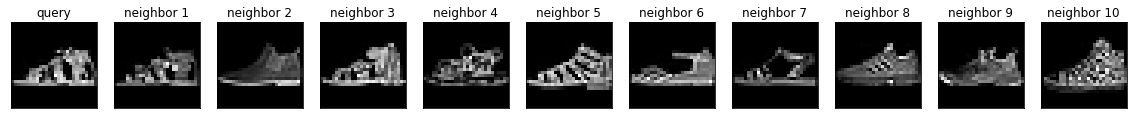

In [23]:
n = np.min((10, len(anns)))
plt.figure(figsize=(20, 4))
ax = plt.subplot(1, n+1, 1)
plt.imshow(x_test[query])
plt.title("query")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i in range(n):
    ax = plt.subplot(1, n+1, i+2)
    plt.imshow(x_train[anns[i][0]])
    plt.title(f"neighbor {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Baseline

In [16]:
cat_query = y_test[query]

In [17]:
baseline_selections = np.random.choice(np.where(y_train == cat_query)[0], n)

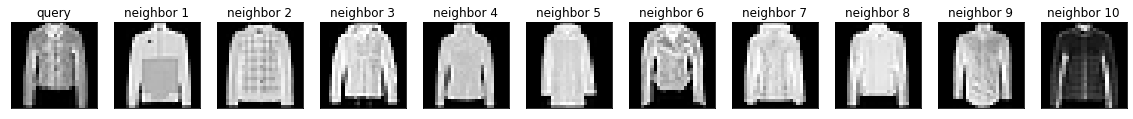

In [18]:
plt.figure(figsize=(20, 4))
ax = plt.subplot(1, n+1, 1)
plt.imshow(x_test[query])
plt.title("query")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for i in range(n):
    ax = plt.subplot(1, n+1, i+2)
    plt.imshow(x_train[baseline_selections[i]])
    plt.title(f"neighbor {i+1}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [19]:
res = autoencoder.predict(x_test[[0]])

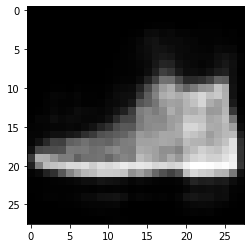

In [20]:
plt.imshow(res[0])